# Modern Portfolio Theory & Machine Learning

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

### Dataframe Declaration

In [2]:
stocks=['AAPL','AMZN','XLK']

AAPL_df=pd.read_csv("data/AAPL.csv")
AMZN_df=pd.read_csv("data/AMZN.csv")
XLK_df=pd.read_csv("data/XLK.csv")

def date_index_conversion(data):
    data.index=data['Date']
    data=data.drop('Date',axis=1)
    data.index=pd.to_datetime(data.index)
    return data
    
AAPL_df=date_index_conversion(AAPL_df)['Close']
AMZN_df=date_index_conversion(AMZN_df)['Close']
XLK_df=date_index_conversion(XLK_df)['Close']
    

full_df=pd.concat([AAPL_df,AMZN_df,XLK_df],axis=1).dropna()
full_df.columns=stocks
print(full_df.head(5))

                 AAPL        AMZN        XLK
Date                                        
2012-01-03  58.747143  179.029999  25.809999
2012-01-04  59.062859  177.509995  25.879999
2012-01-05  59.718571  177.610001  25.959999
2012-01-06  60.342857  182.610001  25.969999
2012-01-09  60.247143  178.559998  25.930000


### Calculating Returns

In [3]:
# Calculating Returns
daily_returns=full_df.pct_change().dropna()
month_df=full_df.resample('BMS').first()
monthly_returns=month_df.pct_change().dropna()
print(monthly_returns.head(5))

                AAPL      AMZN       XLK
Date                                    
2012-02-01  0.109331  0.002402  0.057730
2012-03-01  0.193516  0.003232  0.066667
2012-04-02  0.136206  0.100033  0.046703
2012-05-01 -0.059001  0.161525 -0.018373
2012-06-01 -0.036315 -0.094853 -0.090909


### Volatility calcualtion : By looping through months and calculating volatility on daily returns

In [4]:
covariances={}
for i in monthly_returns.index:
    rtd_idx=daily_returns.index
    mask=(rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    covariances[i]=daily_returns[mask].cov()

print(i)
print(covariances[i])

2019-05-01 00:00:00
          AAPL      AMZN       XLK
AAPL  0.000606  0.000210  0.000261
AMZN  0.000210  0.000261  0.000184
XLK   0.000261  0.000184  0.000197


### Portfolio Weights

We will now generate portfolios to find each month's best one. Using random.random() we generate weights and use it to calcualte volatility & returns. We will store the rrsult in dictionaries, we are generating 1000 random portfolio for each month for the above stocks

In [5]:
portfolio_returns, portfolio_volatility, portfolio_weights={},{},{}

for date in sorted(covariances.keys()):
    cov=covariances[date]
    for portfolio in range(1000):
        # assigning random weights
        weights=np.random.random(3)
        weights/=np.sum(weights)
        
        # assigning returns
        returns=np.dot(weights, monthly_returns.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        
        # Storing returns, vol, weights
        portfolio_returns.setdefault(date,[]).append(returns)
        portfolio_volatility.setdefault(date,[]).append(volatility)
        portfolio_weights.setdefault(date,[]).append(weights)
        
print(portfolio_weights[date][0])
        

[0.28205573 0.207241   0.51070326]


### Plotting efficient Frontier for latest date

Efficient frontier is a plot of volatility vs returns which is helpful to visualise risk/return trade off. Upper left boundary of points is thebest we can do

What you are seeing below is 1000 different cases of weights, volatility and returns for a latest date. The plot tells us on 1 particular day how does volatility and return looks like. We are accustomed to see Efficient Frontier in form of an arc, but since all the returns are +ve we see semi arc


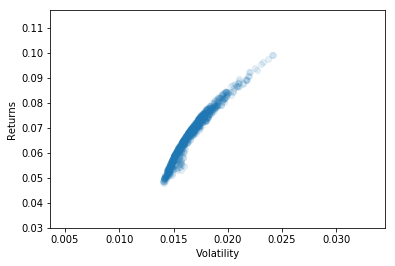

In [6]:
date=sorted(covariances.keys())[-1]

print("What you are seeing below is 1000 different cases of weights, volatility and returns for a latest date. The plot tells us on 1 particular day how does volatility and return looks like. We are accustomed to see Efficient Frontier in form of an arc, but since all the returns are +ve we see semi arc")

# Plot the efficient frontier
plt.scatter(x=portfolio_volatility[date],y=portfolio_returns[date],alpha=0.1)
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.show()

### Get best Sharpe ratios, best portfolio for each month and use it as target variabe in Machine Learning

In [9]:
sharpe_ratio, max_sharpe_idxs={},{}
for date in portfolio_returns.keys():
    for i,ret in enumerate(portfolio_returns[date]):
        sharpe_ratio.setdefault(date,[]).append(ret/portfolio_volatility[date][i])
    # Max Sharpe Ratio
    max_sharpe_idxs[date]=np.argmax(sharpe_ratio[date])

print("For latest date(month) the return for portfolio with max sharpe ratio is ")    
print(date)
print(portfolio_returns[date][max_sharpe_idxs[date]])    

For latest date(month) the return for portfolio with max sharpe ratio is 
2019-05-01 00:00:00
0.08083953409931036


### Building Features for prediction of portfolio returns
1) Target Variables = Best portfolio weights for each month<br>
2) Features - eg EMWA(monthly), we will shift the EWMA for months by 1 month so that they act as predictors


In [10]:
ewma_daily=daily_returns.ewm(span=30).mean()
ewm_monthly=ewma_daily.resample('BMS').first()
ewm_monthly=ewm_monthly.shift(1).dropna()
print(ewm_monthly.iloc[-1])

AAPL    0.003650
AMZN    0.003881
XLK     0.003085
Name: 2019-05-01 00:00:00, dtype: float64


In [11]:
targets, features=[],[]

for date,ewm in ewm_monthly.iterrows():
    best_idx=max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewm)

tagets=np.array(targets)   
features=np.array(features)
print(tagets[-5:])
print(features[-5:])

[[0.91968081 0.02173623 0.05858296]
 [0.0062382  0.01303343 0.98072838]
 [0.04147254 0.01053055 0.9479969 ]
 [0.27367666 0.21649714 0.5098262 ]
 [0.57825045 0.40976142 0.01198813]]
[[-0.00268928  0.00505618  0.00151043]
 [-0.00432658 -0.00015471 -0.00196452]
 [ 0.00337334  0.00046236  0.00248193]
 [ 0.00263916  0.00190069  0.0030597 ]
 [ 0.0036501   0.00388078  0.00308452]]


### Adding Best Sharpe Ratio Portfolio on above Efficient Frontier with an X

### Machine Learning for MPT : Random Forest

In [12]:
from sklearn.ensemble import RandomForestRegressor

train_size=int(0.85 * features.shape[0])
train_features=features[:train_size]
test_features=features[train_size:]


train_targets=targets[:train_size]
test_targets=targets[train_size:]

model=RandomForestRegressor(n_estimators=300,random_state=42)
model.fit(train_features, train_targets)
print(model.score(train_features, train_targets))
print(model.score(test_features, test_targets))

0.8367437878880553
-0.20759893561108148


With the above train model we will use it to get predictions on the test set and compare it with SPY returns. Remeber we are predicting the asset weights and multiply it with stock returns to get total returns which will be compared with SPY returns.


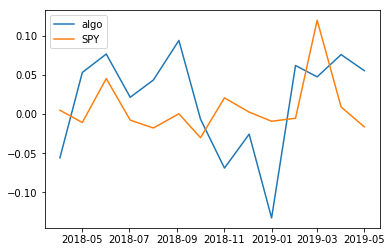

In [14]:
SPY_df=pd.read_csv('data/SPY.csv')
SPY_df=date_index_conversion(SPY_df)['Close']

SPY_df_daily=SPY_df.pct_change().dropna()
SPY_df_month=SPY_df_daily.resample('BMS').first()
SPY_monthly_returns=SPY_df_month.pct_change().dropna()
SPY_monthly_returns=SPY_monthly_returns/100

train_predictions=model.predict(train_features)
test_predictions=model.predict(test_features)

test_returns = np.sum(monthly_returns.iloc[train_size:] *test_predictions, axis=1)
plt.plot(test_returns,label='algo')
plt.plot(SPY_monthly_returns.iloc[train_size:],label='SPY')
plt.legend()
plt.show()

We are doing extreme performance when compared with SPY. At sometimes we are doing extremenly good and at other we are doing not so good. 

### Let's calculate the return on a 1000 Dollar investment

In [15]:
cash =1000
algo_cash, spy_cash=[cash],[cash]

for i in test_returns:
    cash *= 1+i
    algo_cash.append(cash)
    
cash=1000    
for i in SPY_monthly_returns.iloc[train_size:]:
    cash *= 1+i
    spy_cash.append(cash)
    
print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])    
    

algo returns: 0.23171195480388973
SPY returns: 0.10049586429171609


Our Algorithm has performed better than SPY in these months

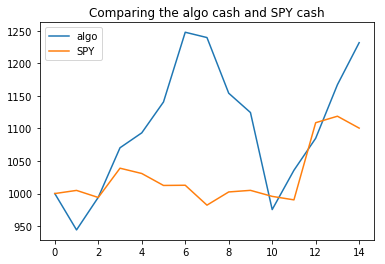

Please don't use this algo for trading purpose, I have taken AMZN, AAPL and tech etf which has by far performed the best in past year, so automatically we see good performance over time


In [16]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash,label='algo')
plt.plot(spy_cash, label='SPY')
plt.legend()# show the legend
plt.title("Comparing the algo cash and SPY cash")
plt.show()

print("Please don't use this algo for trading purpose, I have taken AMZN, AAPL and tech etf which has by far performed the best in past year, so automatically we see good performance over time")